In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

mars = read_csv('data/mars.csv').fillna(0)
rpm = read_csv('data/rpm.csv').fillna(0)
surveys = read_csv('data/surveys.csv')
reject = read_csv('data/reject.csv')

mars = mars[mars.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)
rpm = rpm[rpm.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)
surveys = surveys[surveys.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

In [2]:
counts = mars.groupby('item').shape_set.value_counts()
counts[[71, 55, 30, 45, 11, 29, 16, 17, 23, 58, 35, 76]]

item  shape_set
71    2            105
      1             98
      3             96
55    2            111
      3             96
      1             92
30    2            105
      3             98
      1             96
45    2            105
      1             98
      3             96
11    2            111
      1             95
      3             93
29    2            105
      3             98
      1             96
16    2            105
      1             98
      3             96
17    2            111
      1             96
      3             92
23    2            105
      3             98
      1             96
58    2            105
      1             98
      3             96
35    2            111
      3             99
      1             89
76    2            105
      3             98
      1             96
Name: shape_set, dtype: int64

In [3]:
scores = DataFrame([
    mars.groupby('subject').accuracy.sum(),
    rpm.groupby('subject').accuracy.sum(),
]).T
scores.columns = ['mars', 'rpm']

weights = [0.198,0.216,0.237,0.142,0.374,0.304,0.178,0.458,0.289];
X = 1 - rpm.pivot_table('accuracy','subject','trial').values
err = rpm.trial.max() - scores['rpm']
scores['rpm_adj'] = 60 - (err + np.exp(1.323 + X @ weights))
scores['neuroticism'] = surveys[surveys.filter(regex='neuroticism_q').columns[:-1]].sum(axis=1).values
scores['openness'] = surveys[surveys.filter(regex='openness_q').columns[:-1]].sum(axis=1).values

In [4]:
scores.corr(method='pearson').round(3)

,mars,rpm,rpm_adj,neuroticism,openness
mars,1.000,0.544,0.533,0.135,0.090
rpm,0.544,1.000,0.959,0.074,0.108
rpm_adj,0.533,0.959,1.000,0.085,0.103
neuroticism,0.135,0.074,0.085,1.000,0.110
openness,0.090,0.108,0.103,0.110,1.000


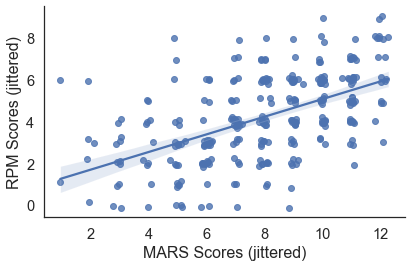

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

scores['mars_x'] = scores['mars'] + np.random.normal(0, 0.1, len(scores))
scores['rpm_y'] = scores['rpm'] + np.random.normal(0, 0.1, len(scores))

sns.regplot(x='mars_x', y='rpm_y', data=scores, ax=ax)
ax.set(xlabel='MARS Scores (jittered)', ylabel='RPM Scores (jittered)')

sns.despine()
plt.tight_layout()


In [6]:
from cmdstanpy import CmdStanModel

zscore = lambda x: (x - np.mean(x)) / np.std(x)

Y = zscore(scores.rpm_adj.values)
X = np.atleast_2d(zscore(scores.mars.values)).T
N, M = X.shape

dd = dict(N=N, M=M, Y=Y, X=X)

StanModel = CmdStanModel(stan_file='stan_models/student_t_reg.stan')

StanFit = StanModel.sample(data=dd, chains=4, parallel_chains=4, iter_warmup=1000, iter_sampling=1000,
                           seed=0, show_progress='notebook')

StanFit.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/szoro/Desktop/projects/mars-irt/04_Validation/stan_models/student_t_reg


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-380.00,0.02300,0.970,-380.00,-380.00,-380.00,1800.0,2100.0,1.0
beta[1],0.56,0.00082,0.048,0.49,0.56,0.64,3376.0,3837.0,1.0
sigma,0.60,0.00000,0.000,0.60,0.60,0.70,3371.7,3831.5,1.0


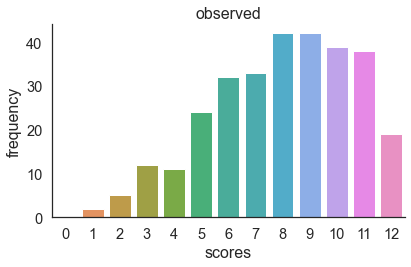

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.countplot(x=scores['mars'], order=np.arange(13), ax=ax)
ax.set(xlabel='scores', ylabel='frequency', title='observed')

sns.despine()
plt.tight_layout()

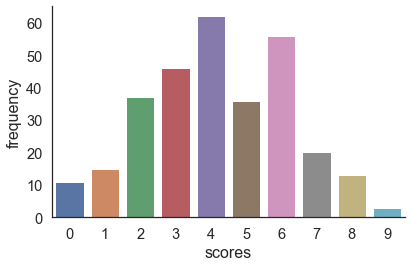

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

sns.countplot(x=scores['rpm'], order=np.arange(10), ax=ax)

ax.set(xlabel='scores', ylabel='frequency')

sns.despine()
plt.tight_layout()

In [9]:
mars.pivot_table('accuracy','item','shape_set')

shape_set,1,2,3
item,,,
11,0.578947,0.585586,0.666667
16,0.714286,0.742857,0.645833
17,0.645833,0.477477,0.423913
23,0.781250,0.647619,0.571429
29,0.822917,0.676190,0.581633
30,0.739583,0.800000,0.755102
35,0.685393,0.576577,0.414141
45,0.765306,0.866667,0.729167
55,0.902174,0.783784,0.822917
